## Import mudules

In [36]:
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [6]:
%cd /content/drive/MyDrive/인공지능 학습관련/covid_classification_softmax
!pwd

/content/drive/MyDrive/인공지능 학습관련/covid_classification_softmax
/content/drive/MyDrive/인공지능 학습관련/covid_classification_softmax


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Multi-input ImageDataGenerator (audio : Mel-spectrogram / image : cropped CXR)

In [20]:
image_path = '../COVID_VS_NON-COVID/cropped_sum_train_test/'
audio_path = '../COVID_VS_NON-COVID/audio_train/'

image_size = 224
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.125)


generator_tra1 = train_datagen.flow_from_directory(
                                    directory=image_path,
                                    subset = 'training',
                                    target_size = (image_size,image_size),
                                    color_mode = 'rgb',
                                    class_mode = 'categorical',
                                    batch_size = batch_size,
                                    shuffle = True,
                                    seed = 126)

generator_tra2 = train_datagen.flow_from_directory(
                                    directory=audio_path,
                                    subset = 'training',
                                    target_size = (image_size,image_size),
                                    color_mode = 'rgb',
                                    class_mode = 'categorical',
                                    batch_size = batch_size,
                                    shuffle = True,
                                    seed = 126)

print(generator_tra1.n)
print(generator_tra2.n)

Found 7250 images belonging to 2 classes.
Found 7250 images belonging to 2 classes.
7250
7250


In [21]:
generator_val1 = train_datagen.flow_from_directory(
                                    directory=image_path,
                                    subset = 'validation',
                                    target_size = (image_size,image_size),
                                    color_mode = 'rgb',
                                    class_mode = 'categorical',
                                    batch_size = batch_size,
                                    shuffle = True,
                                    seed = 126)

generator_val2 = train_datagen.flow_from_directory(
                                    directory=audio_path,
                                    subset = 'validation',
                                    target_size = (image_size,image_size),
                                    color_mode = 'rgb',
                                    class_mode = 'categorical',
                                    batch_size = batch_size,
                                    shuffle = True,
                                    seed = 126)

print(generator_val1.n)
print(generator_val2.n)

Found 1035 images belonging to 2 classes.
Found 1035 images belonging to 2 classes.
1035
1035


In [22]:
# pos, neg 데이터의 수를 맞춰야 같은 라벨을 가져올 수 있다.
def two_image_generator(gen1, gen2):

    while True:
        X1, Y = gen1.next()
        X2, Y = gen2.next()

        yield [X1,X2], Y  #X1i[1] is the label

train_generator = two_image_generator(generator_tra1,generator_tra2)
valid_generator = two_image_generator(generator_val1,generator_val2)

In [11]:
feature_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size,image_size,3),
)

# feature_model.summary()

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
# # 미세 조정을 하려면 처음부터 freezing을 풀어 놓아도 된다.
# feature_model.trainable = True

# print("Number of layers in the base model: ", len(feature_model.layers))
# fine_tune_at = 350

# for layer in feature_model.layers[:fine_tune_at]:
#     layer.trainable =  False

# finetune.summary()

Number of layers in the base model:  707
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 7, 7, 1920)   18321984    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 1)     

In [ ]:
# 이미지 데이터가 매우 많을 때는 featrue model 하단에 GAP레이어를 쌓아서 
# numpy array로 저장되는 데이터의 수를 줄여준다.

# def build_feature_model(feature_model):
#     inputs = Input(shape=(image_size,image_size,3))
#     x = feature_model(inputs)
#     outputs = GlobalAveragePooling2D()(x)
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

# feature_model_GAP = build_feature_model(feature_model)
# feature_model_GAP.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
Total params: 18,321,984
Trainable params: 14,028,480
Non-trainable params: 4,293,504
_________________________________________________________________


## Extract features

In [23]:
# train_labels = []
# train_img_features = []
train_aud_features = []

for i in tqdm(range(generator_tra1.n//batch_size+1)):
    
    [x1, x2] , y = train_generator.__next__()
    # train_labels.extend(y)
    
    # feature1 = feature_model.predict(x1)
    feature2 = feature_model.predict(x2)
    # train_img_features.extend(feature1)
    train_aud_features.extend(feature2)
    
# train_img_features = np.array(train_img_features)
train_aud_features = np.array(train_aud_features)
# train_labels = np.array(train_labels)

# print(train_img_features.shape)
print(train_aud_features.shape)
# print(train_labels.shape)


(7250, 7, 7, 1920)


In [24]:
# train 데이터는 수가 너무많음 따라서 이방법은 train데이터에는 사용 X
# valid_labels = []
# valid_img_features = []
valid_aud_features = []

for i in tqdm(range(generator_val1.n//batch_size+1)):
    
    [x1, x2] , y = valid_generator.__next__()
    # valid_labels.extend(y)
    # feature1 = feature_model.predict(x1)
    feature2 = feature_model.predict(x2)
    # valid_img_features.extend(feature1)
    valid_aud_features.extend(feature2)
    
# valid_img_features = np.array(valid_img_features)
valid_aud_features = np.array(valid_aud_features)
# valid_labels = np.array(valid_labels)

# print(valid_img_features.shape)
print(valid_aud_features.shape)
# print(valid_labels.shape)


(1035, 7, 7, 1920)


## Save features

In [14]:
train_img_path = 'features_sum/train_img.npy'
train_aud_path =  'features_sum/train_aud.npy'
train_labels_path =  'features_sum/train_labels.npy'

valid_img_path = 'features_sum/valid_img.npy'
valid_aud_path =  'features_sum/valid_aud.npy'
valid_labels_path =  'features_sum/valid_labels.npy'

In [25]:
# np.save(train_img_path, train_img_features)
np.save(train_aud_path, train_aud_features)
# np.save(train_labels_path, train_labels)

In [26]:
# np.save(valid_img_path, valid_img_features)
np.save(valid_aud_path, valid_aud_features)
# np.save(valid_labels_path, valid_labels)

## Load features

In [27]:
train_img_features = np.load(train_img_path)
# train_aud_features  = np.load(train_aud_path)
train_labels = np.load(train_labels_path)

valid_img_features = np.load(valid_img_path)
# valid_aud_features = np.load(valid_aud_path)
valid_labels = np.load(valid_labels_path)

## Build and Fit

In [28]:
def build_model():
    
    inputs1 = Input(shape=feature_model.output.shape[1:])
    inputs2 = Input(shape=feature_model.output.shape[1:])

    merged = Concatenate(axis=1)([inputs1, inputs2])

    x = GlobalAveragePooling2D()(merged)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=[inputs1, inputs2],
                 outputs = outputs)
    
    model.compile(optimizer=Adam(lr=4e-4),
                  loss= 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [29]:
# 모델 구축
model = build_model()

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 7, 1920)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 7, 7, 1920)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 7, 1920)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1920)         0           concatenate[0][0]     

In [30]:
weight_path = "multi_model"

cp = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1,
                        save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   min_lr=1e-6)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=30)
callbacks_list = [cp, es, reduceLROnPlat]

In [31]:
initial_epochs = 100

history = model.fit(x = [train_img_features, train_aud_features],
                    y = train_labels,
                    validation_data = ([valid_img_features, valid_aud_features], valid_labels),
                    epochs = initial_epochs,
                    steps_per_epoch = generator_tra1.n//batch_size,
                    validation_steps = generator_val1.n//batch_size,
                    batch_size=batch_size,
                    callbacks = callbacks_list
                    )

model.summary()

Epoch 1/100
226/226 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.7660
Epoch 00001: val_accuracy improved from -inf to 0.91406, saving model to multi_model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: multi_model/assets
226/226 [==============================] - 6s 25ms/step - loss: 0.6077 - accuracy: 0.7660 - val_loss: 0.2234 - val_accuracy: 0.9141
Epoch 2/100
225/226 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.9026
Epoch 00002: val_accuracy improved from 0.91406 to 0.92773, saving model to multi_model
INFO:tensorflow:Assets written to: multi_model/assets
226/226 [==============================] - 6s 27ms/step - loss: 0.2768 - accuracy: 0.9016 - val_loss: 0.1974 - val_accuracy: 0.9277
Epoch 3/100
223/226 [======

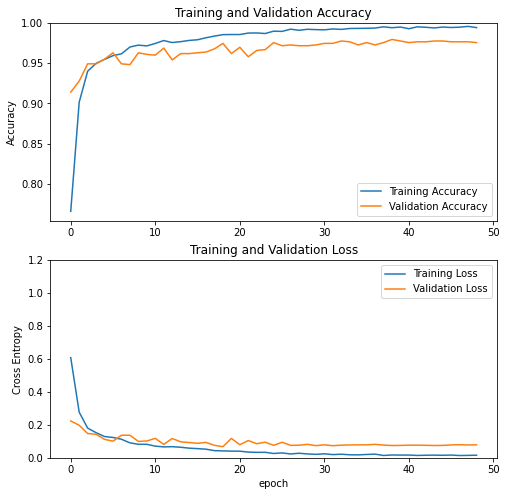

In [32]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('Multi_model_graph.jpg')
plt.show()

In [38]:
model2 = load_model(weight_path)

# # 가중치 로드
# model2.load_model(weight_path)

# 모델 평가
model2.evaluate([valid_img_features,valid_aud_features],valid_labels)

33/33 [==============================] - 0s 7ms/step - loss: 0.0753 - accuracy: 0.9787


[0.07530108094215393, 0.9787439703941345]

In [39]:
model2.save('multi_model_0.9787.h5')

In [ ]:
## 파인튜닝은 시간상 하지 않았다. 또한 오디오 데이터가 잘 정제된 것이 아니라서 큰 의미는 없을 것 같았다.

## Finetuning

In [ ]:
def build_finetuning(model, num_outputs=1):
    
    inputs1 = Input(shape=(image_size, image_size,3))
    inputs2 = Input(shape=(image_size, image_size,3))
    
    x1 = feature_model(inputs1)
    x2 = feature_model(inputs2)
    
    outputs = model([x1,x2])

    model_fine = Model(inputs=[inputs1,inputs2],
                 outputs = outputs)
    init_lr = 2e-6
    opt = Adam(lr=init_lr)
    model_fine.compile(optimizer=opt, 
                    loss= 'binary_crossentropy',
                    metrics='accuracy')
        
    return model_fine

In [ ]:

finetune = build_finetuning(model2)
finetune.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 7, 7, 1920)   18321984    input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 1)            2630657     densenet201[2][0]    

In [ ]:
weight_path="testmodel/best_multi_finetuned.h5"

cp = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   min_lr=1e-7)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [cp, es, reduceLROnPlat]

In [ ]:
fine_tune_epochs = 50

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = finetune.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = total_epochs,
                    steps_per_epoch = generator_tra1.n//batch_size,
                    validation_steps = generator_val1.n//batch_size,
                    initial_epoch= history.epoch[-1],
                    batch_size = batch_size,
                    callbacks = callbacks_list
                    )

finetune.summary()

Epoch 47/150
179/179 [==============================] - ETA: 0s - loss: 0.4150 - accuracy: 0.8963
Epoch 00047: val_accuracy improved from -inf to 0.92352, saving model to testmodel/best_multi_finetuned.h5
179/179 [==============================] - 68s 382ms/step - loss: 0.4150 - accuracy: 0.8963 - val_loss: 0.2966 - val_accuracy: 0.9235
Epoch 48/150
179/179 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9342
Epoch 00048: val_accuracy improved from 0.92352 to 0.92566, saving model to testmodel/best_multi_finetuned.h5
179/179 [==============================] - 56s 313ms/step - loss: 0.2200 - accuracy: 0.9342 - val_loss: 0.3032 - val_accuracy: 0.9257
Epoch 49/150
179/179 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9479
Epoch 00049: val_accuracy did not improve from 0.92566
179/179 [==============================] - 55s 309ms/step - loss: 0.1669 - accuracy: 0.9479 - val_loss: 0.2970 - val_accuracy: 0.9249
Epoch 50/150
179/179 [==========

KeyboardInterrupt: 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([101,101],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([101,101],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('mult_finetune_graph.jpg')
plt.show()

In [ ]:
finetune.save('./Sunspot_traindata_models_and_features/model_tuned.h5')

In [ ]:
# # Make model == feature model
# feature_model = keras.applications.DenseNet201(weights="imagenet", include_top=False)
# feature_model.trainable= False
weight_path="testmodel/best_multi_finetuned.h5"
model3 = build_finetuning(model2)
# 가중치 로드
model3.load_weights(weight_path)

# model3.save('./Sunspot_traindata_models_and_features/best_tuned_Adam_hsv.h5')
# 모델 평가
# valid_generator = two_image_generator(generator_val1,generator_val2) # 초기화
# model3.evaluate(valid_generator)

In [ ]:
model3.save('testmodel/best_multi_finetuned')